<a href="https://colab.research.google.com/github/B-Lorentz/riverine/blob/master/py/real_sph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
from jax import random as rand
from jax import grad, hessian, vmap, jit
from jax import lax
from functools import partial

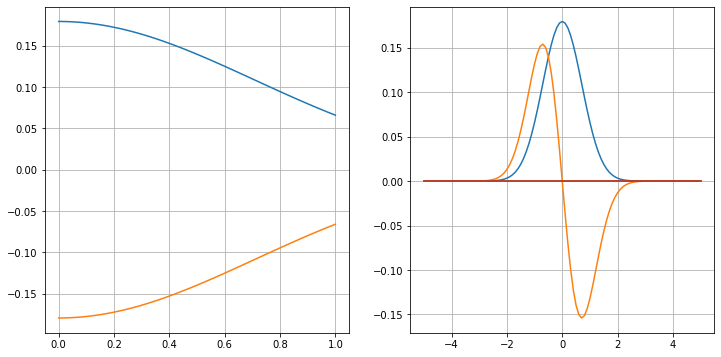

In [2]:
from jax import custom_jvp
id = lambda x: x
def norm1(x):
  return jnp.linalg.norm(x, ord=2, axis=-1)

@custom_jvp
def norm(x):
  return jnp.linalg.norm(x, ord=2, axis=-1)

@norm.defjvp
def norm_jvp(primals, tangents):
  primal_out = norm(primals[0])
  tangent_out = jnp.dot(primals[0]/primal_out, tangents[0])
  return primal_out, tangent_out#lax.cond(jnp.isnan(tangent_out).any(), lambda x:jnp.zeros_like(tangent_out), id, tangent_out)

def W_q(q):
  
  f0 = lambda q: 6.0*(q**3 - q**2) + 1
  f1 = lambda q: 2.0*(1-q)**3
  f2 = lambda q: 0.0
  res = lax.switch(lax.mul(q, 2.0).astype(int), [f0, f1, f2], q)
  return res*8/np.pi

def W_q(q_2):
  res = lax.cond(q_2 < 9, lambda q: jnp.exp(-q), lambda q: 0.0, q_2)
  return res/np.pi**(3/2)
def W(x, h):
  return W_q(((x/h)**2).sum(-1))/h**3
  #return W_q(norm(x)/h)/h**3
def test_W_plot():
  
  def testplot(w, rs, lsp):
 
    ws = vmap(w, 0)(rs)
    dws = vmap(grad(w), 0)(rs)
  
    plt.plot(lsp, ws)
    plt.plot(lsp, dws)
    plt.grid()
  plt.figure(figsize=(12, 6))

  plt.subplot(121)
  lsp = np.linspace(0, 1, 100)
  testplot(W_q, lsp**2, lsp)

  plt.subplot(122)
  w3 = partial(W, h=1.0)
  lsp = np.linspace(-5, 5, 101)
  rs = np.zeros((101, 3))
  rs[:,0] = lsp
  testplot(w3, rs, lsp)
test_W_plot()
#print(jax.jvp(norm1, (np.array([0.0, 0.0, 0.0]),), (jnp.array([1.0, -0.5, 0.1]),)))
#print(jax.jvp(norm, (np.array([0.0, 0.0, 0.0]),), (jnp.array([1.0, -0.5, 0.1]),)))
#grad(norm)(np.array([0.0, 0.0, 0.0]))

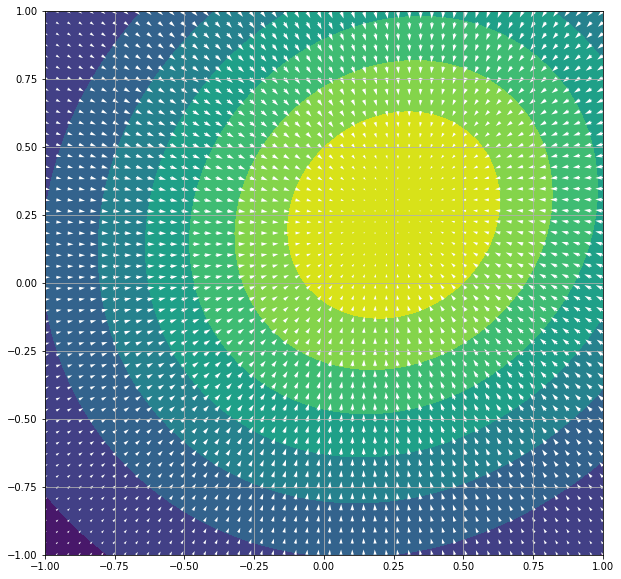

In [3]:
from jax.experimental.maps import xmap


def eval_field(x, x_parts, field, w):
  """x.shape = (3)
      x_parts.shape = (K, 3)
      field.shape = (K, D)
      return.shape = ( D)"""  
 
  dx = x - x_parts
  
  w_ij = vmap(w, 0)(dx)
  return (field*w_ij[:,np.newaxis]).sum(0)

def test_eval_field_plot():
  N = 50
  lsp = np.linspace(-1, 1, N)
  rs = np.stack(np.meshgrid(lsp, lsp, np.zeros(1)), -1)
  parts = np.array([[0.5, 0.5, 0], [-0.0, -0.0, 0]])
  field = np.array([[1.0], [1.0]])
  W_ = partial(W, h=1.0)
  concrete_field = partial(eval_field, x_parts=parts, field=field, w=W_)
  res = vmap(concrete_field, 0)(rs.reshape(-1, 3))
  gra = vmap(jax.jacfwd(concrete_field), 0)(rs.reshape(-1, 3))

  plt.figure(figsize=(10,10))
  x, y = rs[:,:,:,0].squeeze(), rs[:,:,:,1].squeeze()
  plt.contourf(x, y, res.reshape(50, 50))
  gr = gra.reshape(N, N, 3)
  plt.quiver(x, y, gr[:,:,0], gr[:,:,1], color="white")
  plt.grid()

test_eval_field_plot()

101 101
100
(40000, 207, 4)


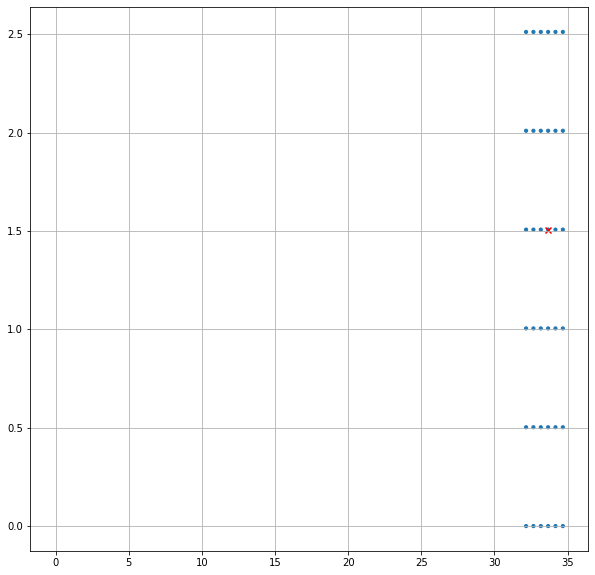

In [5]:
id = lambda x:x
dirs = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
class Grid:
  def __init__(self, Xmax, Ymax, h):
    self.NX, self.NY = int((Xmax+1)/h), int((Ymax+1)/h)
    self.h = h
  def ktip(self, N):
    return int(N/self.NX*N/self.NY)
  def get_bins2d(self, rs):
    x = (rs[...,0]/self.h).astype(int)
    y = (rs[...,1]/self.h).astype(int)
  
    return x, y
  def get_lists(self, x, y, rs, k):
    lists = jnp.zeros((self.NX, self.NY, k, rs.shape[1]))
    inds = jnp.zeros((self.NX, self.NY), dtype=int)

    def addto(i, carry):
      lists, inds = carry
      xi, yi = jnp.take(x, i, axis=0), jnp.take(y, i, axis=0)
      ind = jnp.take(inds, xi*self.NY + yi)
      r = jnp.take(rs, i, axis=0)
      lists = lists.at[xi, yi, ind].set(r)
      inds = inds.at[xi, yi].add(1)
      return lists, inds
  
    lists, inds = lax.fori_loop(0, x.shape[0], addto, (lists, inds))
    return lists

  def get_neighbours(self, x, y, ls):
    ls = ls.reshape(self.NX*self.NY,ls.shape[-2], ls.shape[-1] )
    neighs = [jnp.take(ls, (x)*self.NY + y, axis=0)]
    for dir in dirs:
      neighs.append(jnp.take(ls, (x+dir[0])*self.NY + y+dir[1], axis=0, mode="wrap"))
    return jnp.concatenate(neighs, 1)
 
def test_binning():
  N = 200
  L = 100
  gr = Grid(L, L, 1.0)
  print(gr.NX, gr.NY)
  lsp = np.linspace(0, L, N)
  rs = np.stack(np.meshgrid(lsp, lsp, np.zeros(1)), -1)
  ms = np.ones((N*N, 1))
  rf = rs.reshape(N*N, 3)
  x, y = gr.get_bins2d(rf)
  print(x.max())
  ls = gr.get_lists(x, y, np.concatenate((rf, ms), -1), gr.ktip(N)+20)
  ns = gr.get_neighbours(x, y, ls)
  print(ns.shape)
  plt.figure(figsize=(10, 10))
  i = 667
  plt.scatter(ns[i,:,0], ns[i,:,1], s=ns[i,:,3]*10)
  plt.scatter(rf[i,0], rf[i,1], marker="x", color="r")
  #plt.gca().set(xlim=(0, L), ylim=(0, L))
  plt.grid()
  
test_binning()

In [97]:
def from_state_(state):
  return state[...,:3], state[...,3:6], state[..., 6:7], state[..., 7:8]
def to_state_(rs, vs, ms, cs):
  return jnp.concatenate((rs, vs, ms, cs), -1)
def from_state(state, D):
  
  return from_state_(state[:D]), from_state_(state[D:])
def to_state(rs, vs, ms, cs, s_rs, s_vs, s_ms, s_cs):
  return jnp.concatenate((to_state_(rs, vs, ms, cs), to_state_(s_rs, s_vs, s_ms, s_cs)), 0)
def get_ns(grid, where, state,rs, k):
  x, y = grid.get_bins2d(rs)
  ls = grid.get_lists(x, y, state, k)
  xw, yw = grid.get_bins2d(where)
  return grid.get_neighbours(xw, yw, ls)

def hess_vis(nu):
  def a_vis(sph_in, rs, vs, ms, n_rs, n_vs, n_ms, n_rhos):
    return nu*jnp.diagonal(vmap( hessian(sph_in, argnums=0), (0, 0, 0))(rs, n_rs, n_ms/(n_rhos+1e-7)*n_vs), axis1=-1, axis2=-2).sum(-1)
  return a_vis
def grav(g):
  return lambda x, y: g*np.array([[0, 0, -1.0]])
def make_step(D, eos, a_visf, extern, dt, grid, k, logger=None):
  h = grid.h
  W_ = partial(W, h=h/3)

  def step(state):
    frs, fvs, fms, fcs = from_state_(state)
    (rs, vs, ms, cs), (s_rs, s_vs, s_ms, s_cs) = from_state(state, D)

    (n_rs, n_vs, n_ms, n_cs), (_, _, _, _) = from_state(get_ns(grid, rs, state, frs, k), D)
    #print(rs.shape, n_rs.shape, s_rs.shape)
    sph_in = lambda r, n_r, n_f : eval_field(r, n_r, n_f, w=W_)
    rho = vmap(sph_in, (0, 0, 0))( rs, n_rs, n_ms )
    n_rhos = get_ns(grid, rs, rho, rs, k)
    
    a_ext = extern(rs, vs)
   
    a_vis = a_visf(sph_in, rs, vs, ms, n_rs, n_vs, n_ms, n_rhos)
  
    n_ps = eos(n_rhos)
   
    gr_sph = grad(lambda a, b, c: sph_in(a, b, c).squeeze(), argnums=0)
   
    F_pres = -1/rho*vmap(gr_sph, (0, 0, 0))(rs, n_rs, n_ps)

    vs = vs + (F_pres/ms + a_vis + a_ext)*dt
    
    rs = rs + vs*dt
    if logger is None: 
      return to_state(rs, vs, ms, cs, s_rs, s_vs, s_ms, s_cs)
    else:
      return to_state(rs, vs, ms, cs, s_rs, s_vs, s_ms, s_cs), logger(rs, vs, ms, cs)
  return step
def p_logger(rs, vs, ms, cs):
  return (ms*vs).sum(0)
def start_state(N, L, M, V):
  st = np.zeros((N, 8))
  st[:,:3] = np.random.uniform(0, L, (N, 3))
  st[:,3:6] = np.random.normal(size= (N, 3))*V
  st[:, 6] = M
  return st

def test_step():
  grid = Grid(10, 10, 1.0)
  start = np.concatenate((start_state(1000, 10, 1.0, 1.0), start_state(111, 10, 0.0, 0.0)), 0)
  rh0 = 1000/10**3
  eos = lambda rho: 0.1*jnp.maximum(rho/rh0 - 1, 0)
  stepper = make_step(1000, eos, hess_vis(1.0), grav(9.81), 0.1, grid, 20)
  r = stepper(start)
  print(r.shape)
test_step()

(1111, 8)


In [98]:
def unp_vis(nu):
  def a_vis(sph_in, rs, vs, ms, n_rs, n_vs, n_ms, n_rhos):
    #print(n_vs.shape, vs.shape)
    return nu*vmap( sph_in, (0, 0, 0))(rs, n_rs, n_ms/(n_rhos+1e-7)*(n_vs -vs[:, np.newaxis, :]))
  return a_vis

(17, 17, 40, 8)
5.211726026535034
(1000, 3)
(0, 3)
0.1
(0, 3)
0.023506992
(17, 17, 40, 8)


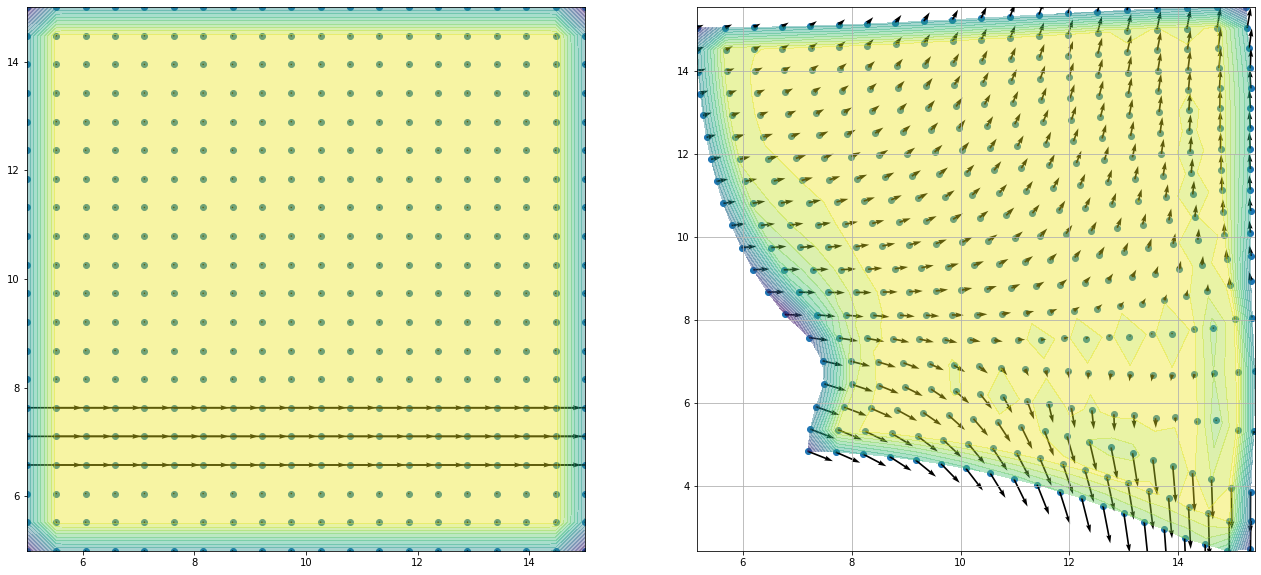

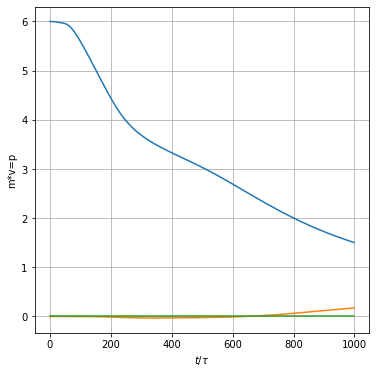

In [105]:
def repeated( update, N):
  return lambda start: jax.lax.fori_loop(0, N, jit(lambda i, s: update(s)), start)

def repeatedL(update, N):
  return lambda start: jax.lax.scan(jit(lambda s, _: update(s)), start, xs=None, length=N)
 
def show_parts(state, D):
    
    (rs, vs, ms, cs), (s_rs, _, _,_) = from_state(state, D)
    print(s_rs.shape)
    plt.scatter(rs[:,0], rs[:, 1])
    plt.scatter(s_rs[:,0], s_rs[:, 1])
    v = np.sqrt((vs**2).sum(-1)).max()
    print(v)
    plt.quiver(rs[:,0], rs[:,1], vs[:,0]/v, vs[:,1]/v, units="xy", scale=1.0)
    plt.grid()
def simple_state(N, L, M, V, dM=0.0):
  st = np.zeros((N*N, 8))
  st[:,:3] = np.stack((np.meshgrid(np.linspace(0, L, N), np.linspace(0, L, N), np.zeros(1))), -1).reshape(N*N, 3)
  st[:,3:6] =np.zeros((N*N, 3))
  st[60:120,3] = V

  st[:, 6] = M
  st[N//2*N +N//2 , 6] += M*dM
  return st
def test_step_plot():
  h = 1.2
  k = 40
  grid = Grid(20, 20, h)
 
  N =20
  firm = start_state(20, 10, 2.0, 0.0)
  firm[:, 0] = 13.4
  firm[:,1] = np.linspace(5,15, 20)
  start = simple_state(N, 10, 1.0, 0.1)
  #start = np.concatenate((simple_state(N, 10, 1.0, 0.1), firm ), 0)
  start[:N**2,:2] += 5.0
 
  (rs, vs, ms, cs), (_, _, _,_) = from_state(start, N**2)
  W_ = partial(W, h=h/3)

  def getrho(state):
    frs, fvs, fms, fcs = from_state_(state)
    (rs, vs, ms, cs), (_, _, _,_) = from_state(state, N**2)
    (n_rs, n_vs, n_ms, n_cs), (_, _, _,_) = from_state(get_ns(grid, rs, state, frs, k), N**2)
    #print("nst:", (n_ms>1.9).sum(-1).sum(-1), n_rs.shape)
    x, y = grid.get_bins2d(frs)
    ls = grid.get_lists(x, y, state, k)
    print(ls.shape)
    mls = ls[:,:,6]
    sph_in = lambda r, n_r, n_f : eval_field(r, n_r, n_f, w=W_)
    return vmap(sph_in, (0, 0, 0))( rs, n_rs, n_ms ), rs, (mls>1.9).sum(-1)
  def wall(p):
    return lambda rs, vs: ((rs[:,0:1]>p)*(rs[:,0:1]-p)**2)*np.array([-1.0, 0.0, 0.0])
  rho0, rs, ch = getrho(start)
  rho00 = np.median(rho0)*1.01
  print(rho00)
  eos = lambda rho: 10.4*jnp.maximum(rho/rho00 - 1, 0)
  r2d = rs.reshape(N, N, 3)
 
  stepper = make_step(N**2,eos, unp_vis(3.0), wall(15.3), 0.1, grid, k, p_logger)
  plt.figure(figsize=(22, 10))
  r, log = repeatedL(stepper, 1000)(start)
  print(log.shape)
  plt.subplot(121)
  show_parts(start, N**2)
  i = 131
  #plt.scatter(n_rs[i,:,0], n_rs[i,:, 1], s=n_ms[i]*10, c="r", marker="x")
  #plt.scatter(rs[i,0], rs[i, 1], marker="*", s=100, c="black")
  plt.contourf(r2d[:,:,0], r2d[:,:,1], rho0.reshape(N, N), levels=20,  alpha=0.4)
  #plt.imshow(rho0.reshape(N, N))
  
  plt.grid()
  plt.subplot(122)
  show_parts(r.to_py(),N**2)
  rho0, rs1, ch = getrho(r)
  r2d = rs1.reshape(N, N, 3)
  plt.contourf(r2d[:,:,0], r2d[:,:,1], rho0.reshape(N, N), levels=20,  alpha=0.4)
  plt.figure(figsize=(6,6))
  plt.plot(log)
  plt.grid()
  plt.xlabel(r"$t/\tau$")
  plt.ylabel("m*v=p")

test_step_plot()